In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/texturemodel/code/'
sys.path.insert(0,codepath)

from utils import default_paths
from feature_extraction import texture_statistics_pyramid, texture_feature_utils
from plotting import plot_utils

import h5py


In [2]:
names = texture_feature_utils.feature_type_names_simple

# run "texture_feat_utils.make_feature_column_labels()" to create this
raw_feat_columns = pd.read_csv(os.path.join(default_paths.pyramid_texture_feat_path, \
                           'feature_column_labels_%dori_%dsf.csv'%(4,4)))
_ , counts_raw = np.unique(raw_feat_columns['feature_type_simple'], return_counts=True)
counts_raw

array([  6,  16,  16,  11, 272,  98,  24,  34,  48, 116])

#### Find the dimension of each feature type for each pRF, after PCA

In [3]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

n_feature_types = len(names)
n_prfs = 1456;
n_comp_each = np.zeros((n_subjects, n_feature_types, n_prfs))

for si, ss in enumerate(subjects):

    featpath = default_paths.pyramid_texture_feat_path
    featfilename = os.path.join(featpath, 'PCA','S%d_4ori_4sf_pcaHL_concat_grid5.h5py'%ss)
    
    with h5py.File(featfilename, 'r') as f:
        feats = f['/features'][0,:,:]
    
    cols, _ = texture_feature_utils.get_feature_inds_pca('S%d'%ss)
    
    for ff in range(n_feature_types):
        vals = feats[cols==ff,:]
        n_comp_each[si,ff,:] = np.sum(~np.isnan(vals), axis=0)


#### Make a table of numbers

In [4]:
pca_feat_inds = np.arange(4,10)

vals = np.zeros((len(pca_feat_inds), 3))
is_same = np.zeros((len(pca_feat_inds), n_prfs))

for fi, ff in enumerate(pca_feat_inds):
    
    # all ncomp values across pRFs and subjects
    # (mostly they are same across subjects)
    n = n_comp_each[:,ff,:].ravel()
    vals[fi,0] = np.median(n)
    vals[fi,1] = np.min(n)
    vals[fi,2] = np.max(n)
    
    is_same[fi,:] = np.all(n_comp_each[0:1,ff,:]==n_comp_each[:,ff,:], axis=0)


In [5]:
vals_all = np.concatenate([np.tile(np.array(['-']), [4,3]), vals.astype(int)], axis=0)
vals_all = np.concatenate([counts_raw[:,None].astype('int'), vals_all], axis=1)
df = pd.DataFrame(data=vals_all, \
             columns=['raw','median','min','max'],
             index=names)
fn2save = os.path.join(default_paths.fig_path, 'nfeat_eachgroup.csv')
print(fn2save)
df.to_csv(fn2save)
df

/user_data/mmhender/texturemodel/figures/nfeat_eachgroup.csv


,raw,median,min,max
pixel,6,-,-,-
energy-mean,16,-,-,-
linear-mean,16,-,-,-
marginal,11,-,-,-
energy-auto,272,4,3,12
linear-auto,98,9,6,16
energy-cross-orient,24,5,4,6
linear-cross-orient,34,4,3,9
energy-cross-scale,48,7,5,12
linear-cross-scale,116,14,7,22


#### Group by pRF size 

In [7]:
from model_fitting import initialize_fitting
prf_params = initialize_fitting.get_prf_models(5)

size  = prf_params[:,2] * 8.4;
ecc = np.sqrt(prf_params[:,0]**2 + prf_params[:,1]**2) * 8.4;


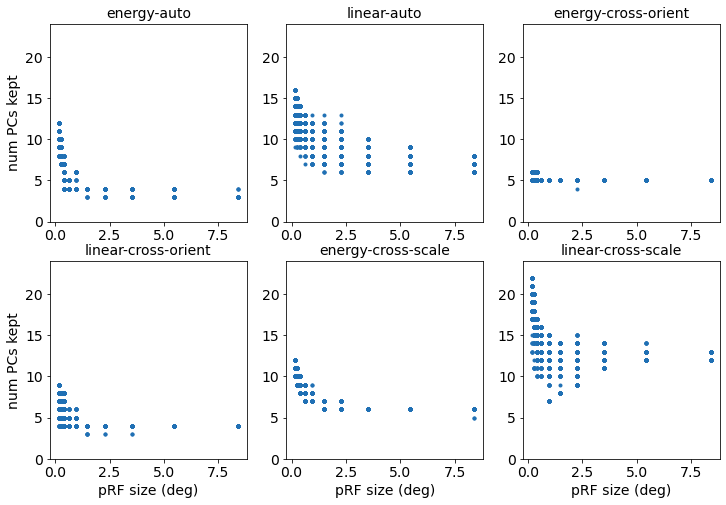

In [8]:
plt.figure(figsize=(12,8))
plot_utils.set_all_font_sizes(14)
color = cm.Blues(np.linspace(0,1,5))[3,:]
for fi, ff in enumerate(np.arange(4,10)):
   
    plt.subplot(2,3,fi+1)
    plt.plot(size, n_comp_each[:,ff,:].T,'.',color=color)
    plt.title(names[ff])
    plt.ylim([0, 24])
    if fi>2:
        plt.xlabel('pRF size (deg)')
    if np.mod(fi,3)==0:
        plt.ylabel('num PCs kept')
        
filename_save = os.path.join(default_paths.fig_path,'num_pcs_versus_prf_size.png')
plt.savefig(filename_save)

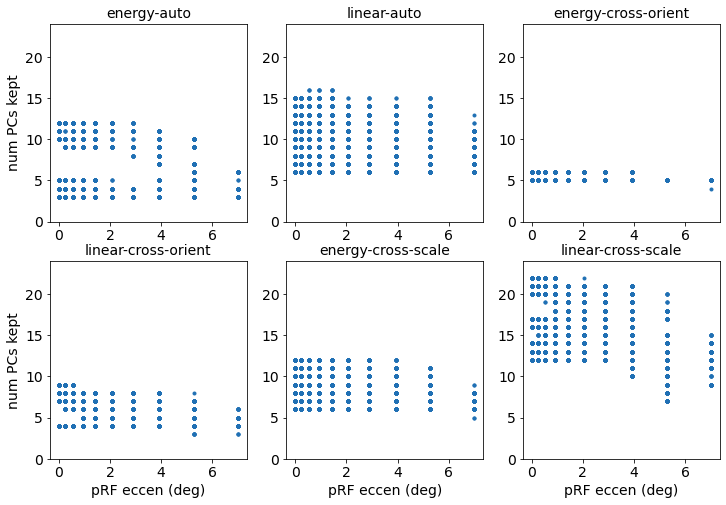

In [9]:
plt.figure(figsize=(12,8))
color = cm.Blues(np.linspace(0,1,5))[3,:]
plot_utils.set_all_font_sizes(14)


for fi, ff in enumerate(np.arange(4,10)):
   
    plt.subplot(2,3,fi+1)
    plt.plot(ecc, n_comp_each[:,ff,:].T,'.',color=color)
    plt.title(names[ff])
    plt.ylim([0, 24])
    if fi>2:
        plt.xlabel('pRF eccen (deg)')
    if np.mod(fi,3)==0:
        plt.ylabel('num PCs kept')
        
filename_save = os.path.join(default_paths.fig_path,'num_pcs_versus_prf_eccen.png')
plt.savefig(filename_save)

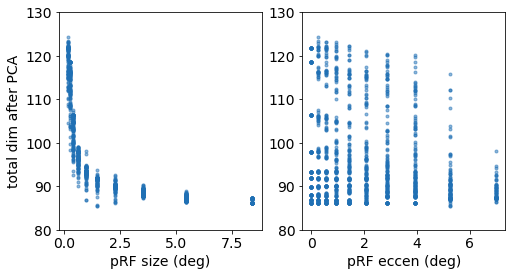

In [10]:
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(8,4))
color = cm.Blues(np.linspace(0,1,5))[3,:]
total_dim = np.mean(np.sum(n_comp_each, axis=1), axis=0)

plt.subplot(1,2,1)
plt.plot(size, total_dim, '.',color=color, alpha=0.5)
plt.xlabel('pRF size (deg)')
plt.ylabel('total dim after PCA')
plt.ylim([80,130])

plt.subplot(1,2,2)
plt.plot(ecc, total_dim, '.',color=color, alpha=0.5)
plt.xlabel('pRF eccen (deg)')
plt.ylim([80,130])

filename_save = os.path.join(default_paths.fig_path,'num_pcs_versus_prf_params.pdf')
plt.savefig(filename_save)
 